<a href="https://colab.research.google.com/github/FranciscoAguiar/DataScienceProgramming/blob/master/ProcessingTwitters_UEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise das mensagens trocadas por usuários do Twitter sobre a COVID-19


**Disciplina**: Programação para Ciência de Dados  
**Autores**: Francisco de Assis Marinho Aguiar e Leandro da Cruz Farias     
**Github:** https://github.com/FranciscoAguiar/DataScienceProgramming   
**Fonte de dados:** http://tiagodemelo.info/datasets/dados-curso-completo.csv.tar.gz

## Preparação do notebook

### Download do conjunto de dados

In [1]:
!wget http://tiagodemelo.info/datasets/dados-curso-completo.csv.tar.gz
!tar -xvf dados-curso-completo.csv.tar.gz

--2020-10-09 21:32:48--  http://tiagodemelo.info/datasets/dados-curso-completo.csv.tar.gz
Resolving tiagodemelo.info (tiagodemelo.info)... 108.167.188.189
Connecting to tiagodemelo.info (tiagodemelo.info)|108.167.188.189|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143340808 (137M) [application/x-gzip]
Saving to: ‘dados-curso-completo.csv.tar.gz.4’

dados-curso-complet 100%[===================>] 136.70M  14.6MB/s    in 11s     

2020-10-09 21:33:00 (12.6 MB/s) - ‘dados-curso-completo.csv.tar.gz.4’ saved [143340808/143340808]

dados-curso-completo.csv


### Instalação de bibliotecas

In [2]:
!pip install geopandas
!pip install wordcloud

### Importação das bibliotecas

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import nltk
import datetime
from pandas import DataFrame
import seaborn as sns

from shapely.geometry import Point
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

pd.set_option('display.max_colwidth', None)
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Análise dos dados dos tweets

In [4]:
tweets_df = pd.read_csv('dados-curso-completo.csv')
tweets_df.head(n=10) # Return the first n rows

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-03-23 18:51:14,Gaboardi,fraslee,@BolsonaroSP Cade o fundão deputado??? Congresso está sentado em 3BI olhando a pandemia da janela.,0,138,pt,NaN,NaN,NaN,NaN,NaN,[]
1,2020-03-18 03:18:14,Seu Zé da Farmácia,seuzedafarmacia,"Em ação preventiva, o Governo do Estado suspendeu as aulas da rede estadual até 31 de março. ⁣\n⁣\nEsta ação está ali… https://t.co/EPFXOMtwSY",0,56,pt,NaN,NaN,NaN,NaN,NaN,[]
2,2020-03-29 12:09:27,Marília Oliveira 🇧🇷,Marioliveira_gb,Incrível como os defensores do fim do distanciamento social fazem parecer que as pessoas com alguma doença pré-exis… https://t.co/oEyXDF9cDy,0,5,pt,NaN,NaN,NaN,NaN,NaN,[]
3,2020-04-01 21:11:07,🚩,santosodeto,Fumaça de cigarro pode propagar coronavírus? https://t.co/JT1oMiUCXf,0,1885,pt,NaN,NaN,NaN,NaN,NaN,[]
4,2020-03-19 17:49:40,Nova Impressão,novaimpressao_,🚨Todos juntos contra COVID-19💪\n\nSolicite seu material por e-mail ou WhatsApp. Caso venha até a empresa traga seu ma… https://t.co/p6wcoomynZ,0,124,pt,Brasília,Brazil,BR,-47.8778,-15.77691,[]
5,2020-05-08 11:21:36,Marcel Silvano,marcelsilvano,"Importantes avanços! A pesquisa brasileira, a nossa Universidade Pública demostrando compromisso com a sociedade.… https://t.co/dj4w3M7e5R",4,2769,pt,Macaé,Brazil,BR,NaN,NaN,[]
6,2020-03-10 21:27:40,Teixeira Correia,LidadorNoticias,(Última hora) Volta ao Alentejo: Anulada por causa do Coronavírus. https://t.co/VawVSD4y5R,0,39,pt,NaN,NaN,NaN,NaN,NaN,[]
7,2020-06-04 13:22:21,Thiago Moraes,ThiagoMoraesPB,João Pessoa tem queda no isolamento social por dois dias consecutivos https://t.co/pOCB4VJqzr,1,3578,pt,NaN,NaN,NaN,NaN,NaN,[]
8,2020-05-07 21:32:12,PT Brasil,ptbrasil,A #tvPT de hoje vai falar sobre a pandemia na situação jurídica de Bolsonaro. Acompanhe a partir das 19h nas nossas… https://t.co/c9RPAjCjKz,10,942696,pt,NaN,NaN,NaN,NaN,NaN,['tvPT']
9,2020-03-11 20:27:49,Niquito ;),NLazaroto,O Coronavirús causou uma pandemia e eu ainda n me declarei pra morena,0,215,pt,NaN,NaN,NaN,NaN,NaN,[]


Total de registros:

In [5]:
len(tweets_df.index)

1658825

In [6]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1658825 entries, 0 to 1658824
Data columns (total 13 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   data        1658825 non-null  object 
 1   usuario     1658768 non-null  object 
 2   apelido     1658825 non-null  object 
 3   texto       1658825 non-null  object 
 4   retweet     1658825 non-null  int64  
 5   seguidores  1658825 non-null  int64  
 6   idioma      1658825 non-null  object 
 7   lugar       74605 non-null    object 
 8   pais        74600 non-null    object 
 9   sigla       74595 non-null    object 
 10  latitude    8720 non-null     float64
 11  longitude   8720 non-null     float64
 12  hashtags    1658825 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 164.5+ MB


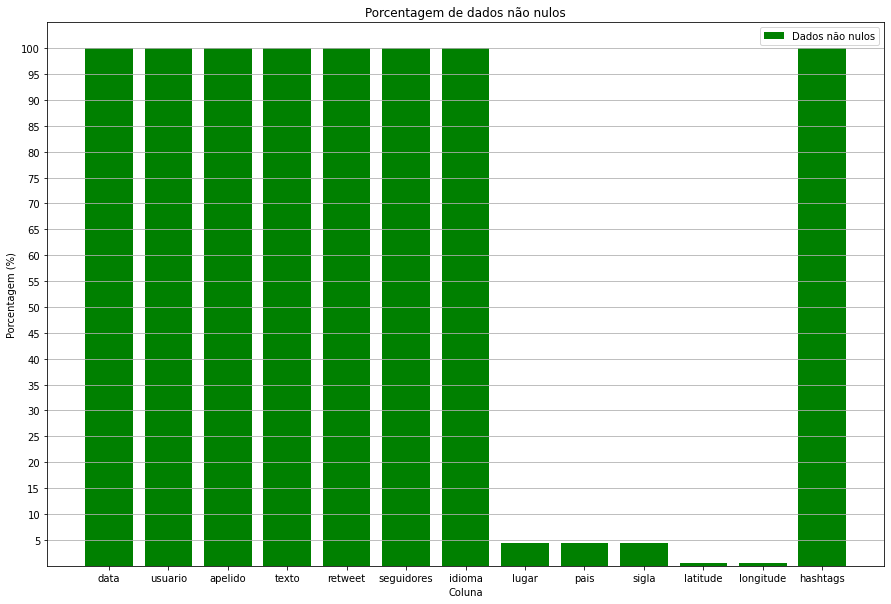

In [7]:
y = []
for label, column in tweets_df.items():
  y.append(column.notnull().mean() * 100)

plt.subplots(figsize=(15, 10))
plt.bar(tweets_df.columns, y, label="Dados não nulos", color='g')
plt.yticks(np.arange(5, max(y) + 1, 5))
plt.legend()
plt.grid(axis='y')
plt.xlabel('Coluna')
plt.ylabel('Porcentagem (%)')
plt.title('Porcentagem de dados não nulos')
plt.show()

### Quantidade de tweets por idioma

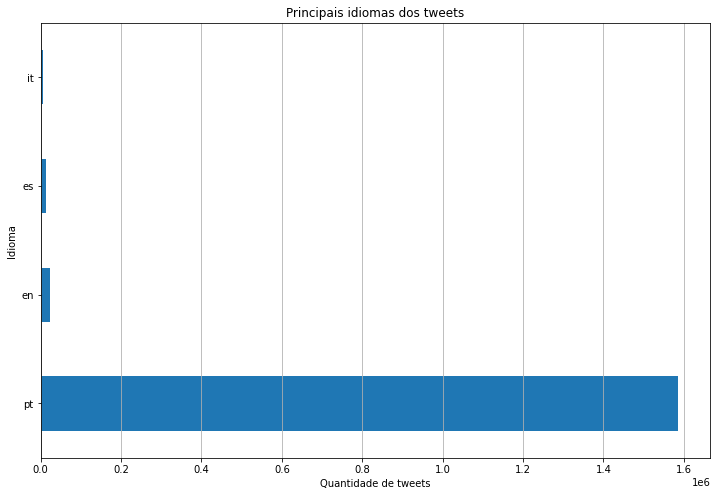

In [8]:
tweets_df.groupby('idioma').idioma.count().nlargest(4).plot(kind='barh', figsize=(12, 8))
plt.title('Principais idiomas dos tweets')
plt.xlabel('Quantidade de tweets')
plt.ylabel('Idioma')
plt.grid(axis='x')
plt.show()

### Quantidade de tweets por país

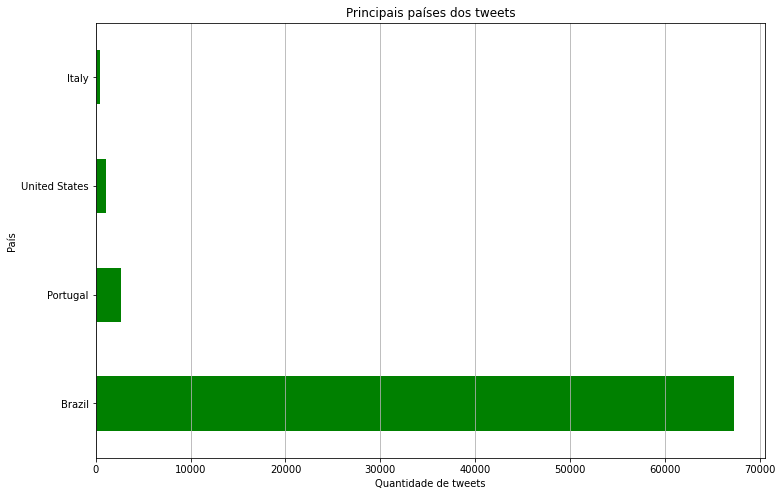

In [9]:
tweets_df.groupby('pais').pais.count().nlargest(4).plot(kind='barh', figsize=(12, 8), color='g')
plt.title('Principais países dos tweets')
plt.xlabel('Quantidade de tweets')
plt.ylabel('País')
plt.grid(axis='x')
plt.show()

### Quantidade de tweets por mês no primeiro semestre de 2020

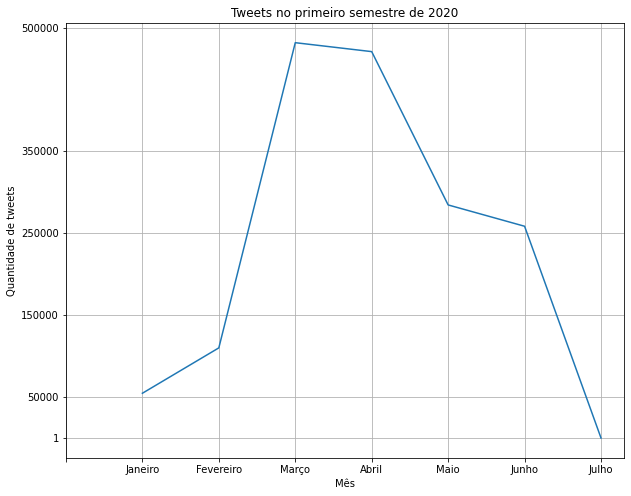

In [10]:
tweets_df.data = pd.to_datetime(tweets_df.data)
tweets_df.groupby(tweets_df.data.dt.month).texto.count().plot(figsize=(10, 8), yticks=[1, 50000, 150000, 250000, 350000, 500000])
plt.title('Tweets no primeiro semestre de 2020')
plt.xlabel('Mês')
plt.ylabel('Quantidade de tweets')
plt.xticks(ticks=np.arange(8), labels=[None, 'Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho'])
plt.grid()
plt.show()

### Tweets pelo mundo

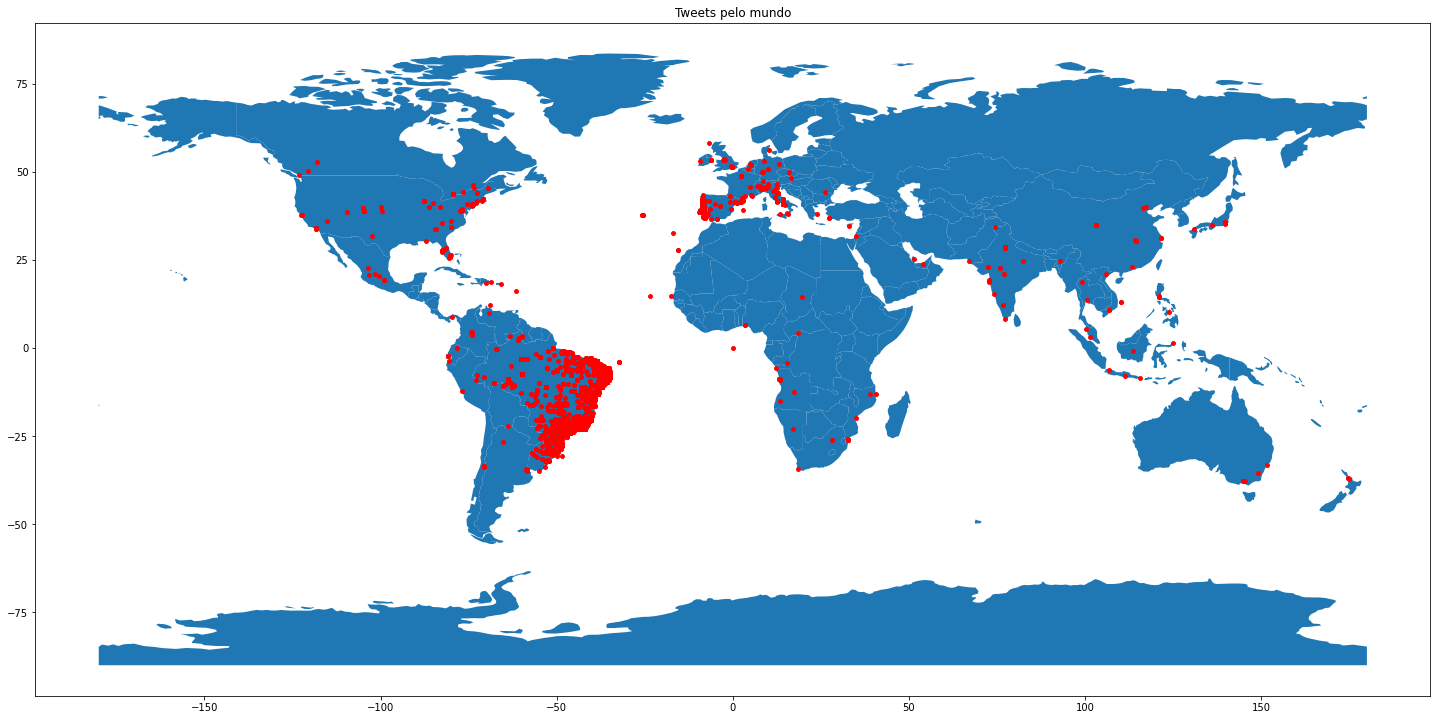

In [11]:
world_tweets_df = tweets_df.loc[tweets_df.latitude.notnull() & tweets_df.longitude.notnull()]
geometry = [Point(xy) for xy in zip(world_tweets_df.latitude, world_tweets_df.longitude)]
location_dic = {'tweet': world_tweets_df.texto, 'geometry': geometry}
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

tweets_gdf = gpd.GeoDataFrame(location_dic, geometry=geometry)
tweets_gdf.plot(ax=world.plot(figsize=(25, 20)), marker='o', color='red', markersize=15)
plt.title('Tweets pelo mundo')
plt.show()

### Tweets pelo Brasil

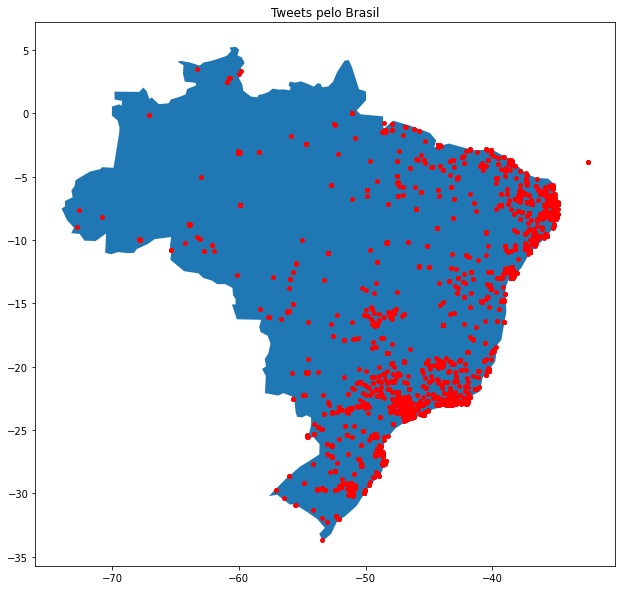

In [12]:
country = 'Brazil'
localized_tweets_df = tweets_df.loc[tweets_df.latitude.notnull() & tweets_df.longitude.notnull() & tweets_df.pais.eq(country)]
geometry = [Point(xy) for xy in zip(localized_tweets_df.latitude, localized_tweets_df.longitude)]
location_dic = {'tweet': localized_tweets_df.texto, 'geometry': geometry}
brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).loc[world.name == country]

tweets_gdf = gpd.GeoDataFrame(location_dic, geometry=geometry)
tweets_gdf.plot(ax=brazil.plot(figsize=(15, 10)), marker='o', color='red', markersize=15)
plt.title('Tweets pelo Brasil')
plt.show()

# Mapa de Calor


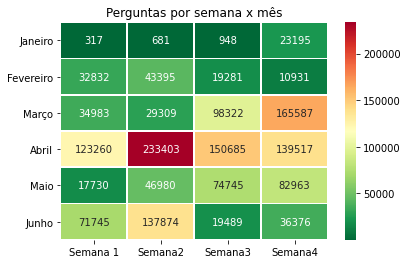

In [46]:
def heatMap(dataframe, title):
  Index= ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio','Junho']
  Cols = ['Semana 1', 'Semana2', 'Semana3', 'Semana4']
  c = np.zeros([6,4]);

  df1 = dataframe.groupby(dataframe.data.dt.isocalendar().week).size()
  row_ = 0
  col_ = 0
  for index, item in enumerate(df1):
     #print (index, item)
     c[row_,col_] = item
     col_+=1
     if (col_ % 4 == 0):
        row_+=1
        col_=0
     if (row_ >=6 ):
       break  


  df = DataFrame(c, index=Index, columns=Cols)       

  plt.title(title)


  sns.heatmap(df, cmap='RdYlGn_r' , annot=True, linewidths=0.8, fmt='.7g')


heatMap(tweets_df,'Perguntas por semana x mês')

# Perguntas no Twitter

## Dados das perguntas

Filtragem por coluna.

Uso da biblioteca NLTK

In [14]:
questions_df = tweets_df.loc[tweets_df.texto.str.contains('?', regex=False)]
new_rows = []

for row in questions_df.itertuples():
  sentences = nltk.sent_tokenize(row.texto)

  for sentence in sentences:
    if '?' in sentence and len(sentence) > 2:
      new_rows.append((row.data, row.usuario, row.apelido, sentence, row.retweet, row.seguidores, row.idioma, row.lugar, row.pais, row.sigla, row.latitude, row.longitude, row.hashtags))

questions_df = pd.DataFrame(new_rows, columns=tweets_df.columns.array)
questions_df

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-03-23 18:51:14,Gaboardi,fraslee,@BolsonaroSP Cade o fundão deputado???,0,138,pt,NaN,NaN,NaN,NaN,NaN,[]
1,2020-04-01 21:11:07,🚩,santosodeto,Fumaça de cigarro pode propagar coronavírus?,0,1885,pt,NaN,NaN,NaN,NaN,NaN,[]
2,2020-06-25 11:09:19,Andreia Peraro,AndreiaPeraro,@ipratesMD @dr_pampers Será que corremos o risco de termos piolhos super resistentes?,0,86,pt,NaN,NaN,NaN,NaN,NaN,[]
3,2020-04-06 15:44:36,Diorgenes Pandini,diorpandini,Prioridade ?!,0,219,pt,NaN,NaN,NaN,NaN,NaN,"['COVID19', 'floripa', 'isolamento']"
4,2020-03-30 00:43:36,Valnei do Val,vdoval,"Que tal uma notícia boa, indo na contramão do que a mídia corrupta está fazendo (tocando o terror na população)?",0,201,pt,NaN,NaN,NaN,NaN,NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198080,2020-05-25 22:53:13,O que houve com a couve?,couveluiza,Ansiedade?,0,1883,pt,NaN,NaN,NaN,NaN,NaN,[]
198081,2020-05-25 22:53:13,O que houve com a couve?,couveluiza,Angústia?,0,1883,pt,NaN,NaN,NaN,NaN,NaN,[]
198082,2020-05-25 22:53:13,O que houve com a couve?,couveluiza,Covid?,0,1883,pt,NaN,NaN,NaN,NaN,NaN,[]
198083,2020-03-13 17:26:18,broca,whoisdrill,oms: tamo tendo pandemia evitar\n conglomerados\n\nunis*l: que tal uma aula no juri???,0,361,pt,NaN,NaN,NaN,NaN,NaN,[]


In [15]:
questions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198085 entries, 0 to 198084
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   data        198085 non-null  datetime64[ns]
 1   usuario     198078 non-null  object        
 2   apelido     198085 non-null  object        
 3   texto       198085 non-null  object        
 4   retweet     198085 non-null  int64         
 5   seguidores  198085 non-null  int64         
 6   idioma      198085 non-null  object        
 7   lugar       8935 non-null    object        
 8   pais        8935 non-null    object        
 9   sigla       8935 non-null    object        
 10  latitude    661 non-null     float64       
 11  longitude   661 non-null     float64       
 12  hashtags    198085 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(8)
memory usage: 19.6+ MB


**Quantidade de perguntas por idioma**

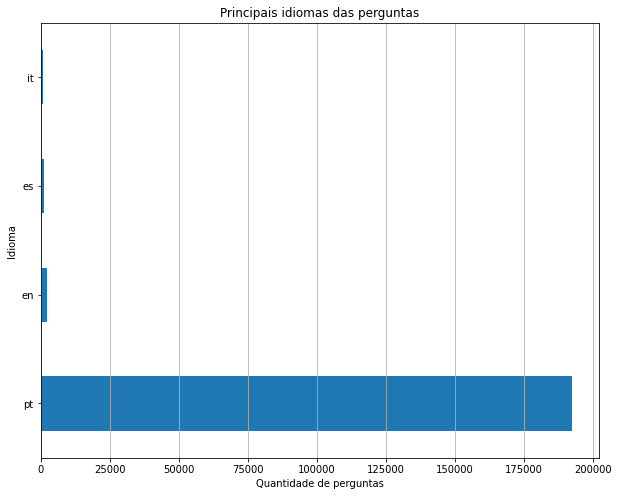

In [16]:
questions_df.groupby('idioma').idioma.count().nlargest(4).plot(kind='barh', figsize=(10, 8))
plt.title('Principais idiomas das perguntas')
plt.xlabel('Quantidade de perguntas')
plt.ylabel('Idioma')
plt.grid(axis='x')
plt.show()

**Quantidade de perguntas por país**

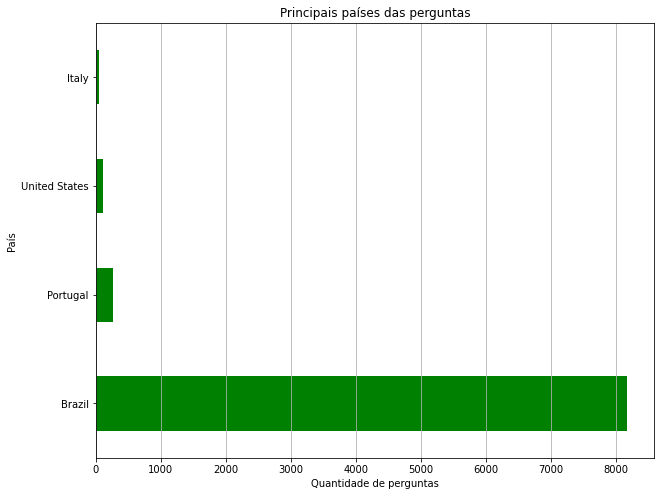

In [17]:
questions_df.groupby('pais').pais.count().nlargest(4).plot(kind='barh', figsize=(10, 8), color ='g')
plt.title('Principais países das perguntas')
plt.xlabel('Quantidade de perguntas')
plt.ylabel('País')
plt.grid(axis='x')
plt.show()

**Perguntas por mês**

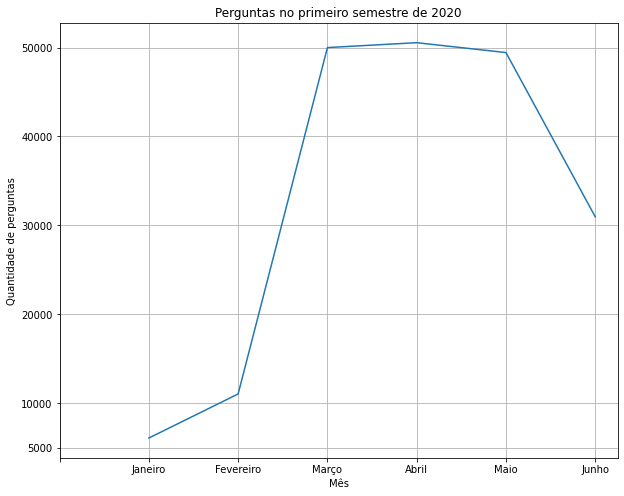

In [18]:
questions_df.groupby(questions_df.data.dt.month).texto.count().plot(figsize = (10, 8), yticks=[5000, 10000, 20000, 30000, 40000, 50000])
plt.title('Perguntas no primeiro semestre de 2020')
plt.xlabel('Mês')
plt.ylabel('Quantidade de perguntas')
plt.xticks(ticks=np.arange(7), labels=[None, 'Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho'])
plt.grid()
plt.show()

Houve aumento considerável no número de perguntas a partir do mês de fevereiro até o mês de março. A partir de então, o número de perguntas se manteu próximo a 50000 até o mês de maio, onde iniciou uma queda nas perguntas.

**Perguntas no Brasil**

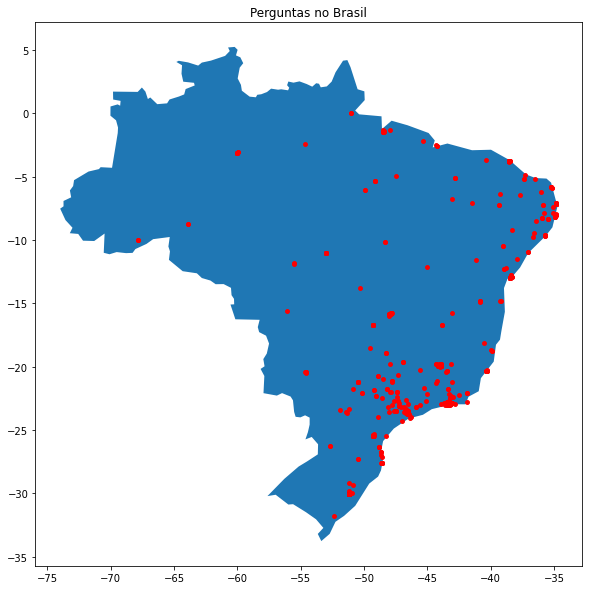

In [19]:
country = 'Brazil'
localized_tweets_df = questions_df.loc[questions_df.latitude.notnull() & questions_df.longitude.notnull() & questions_df.pais.eq(country)]
geometry = [Point(xy) for xy in zip(localized_tweets_df.latitude, localized_tweets_df.longitude)]
location_dic = {'tweet': localized_tweets_df.texto, 'geometry': geometry}
brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).loc[world.name == country]

tweets_gdf = gpd.GeoDataFrame(location_dic, geometry=geometry)
tweets_gdf.plot(ax=brazil.plot(figsize=(15, 10)), marker='o', color='red', markersize=15)
plt.title('Perguntas no Brasil')
plt.show()

**Nuvem de palavras das perguntas**

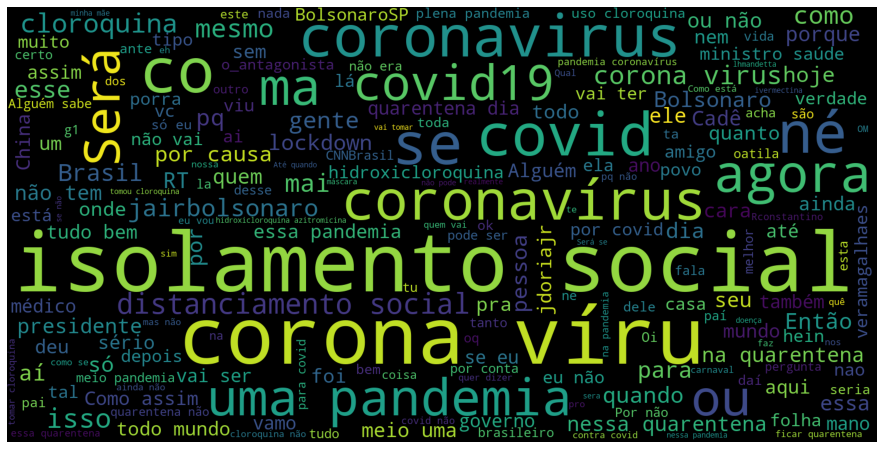

In [20]:
stopwords = set(STOPWORDS)
stopwords.update(["da", "meu", "em", "você", "de", "ao", "os","http","https","que"])
all_tweets = " ".join(s for s in questions_df.texto)
wordcloud = WordCloud(stopwords=stopwords, background_color='black', width=1600, height=800).generate(all_tweets)

fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)
plt.show()

## Temas discutidos em perguntas no Twitter

### Doença

In [21]:
is_disease = questions_df.texto.str.contains('covid|corona|vírus|virus|doença|doenca|pandemia|gripe|pneumonia|sintoma|comorbidade|febre|tosse|falta de ar|olfato|paladar', na=False, case=False)
disease_tweets_df = questions_df.loc[is_disease]
disease_tweets_df

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
1,2020-04-01 21:11:07,🚩,santosodeto,Fumaça de cigarro pode propagar coronavírus?,0,1885,pt,NaN,NaN,NaN,NaN,NaN,[]
5,2020-04-07 23:19:44,Mauricio Ligabo,LigaboMauricio,@JoseMedeirosMT Seria isso algum tipo aleatório de demência provocando pelo coronavírus?,0,23,pt,NaN,NaN,NaN,NaN,NaN,[]
6,2020-04-13 19:16:51,Gus,arrombagus,"""Nova York é o novo epicentro da pandemia de corona vírus""\n\nTa agora eu lhe pergunto cadê os vingadores?",3,253,pt,Santos,Brazil,BR,NaN,NaN,[]
9,2020-04-02 13:04:55,Luizcarlosdospatetas@hotmail.com,Luizcarlosdosp5,#perguntacorona \nQuero saber se a covid tem cura?,0,0,pt,NaN,NaN,NaN,NaN,NaN,['perguntacorona']
11,2020-04-02 13:56:41,Cândido Henrique,candidoh,"E essa chuvinha boa para pegar um resfriado e confundir com Covid-19, hem?",0,3254,pt,NaN,NaN,NaN,NaN,NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198072,2020-02-04 21:57:15,beatri💤️️,zaylenasouls,o que que é o corona vírus perto das beliebers?,4,23284,pt,NaN,NaN,NaN,NaN,NaN,[]
198075,2020-02-07 07:04:03,PT®️,ultratmr,@acruz39 Andas a fazer tratamentos ao Coronavirus?,0,977,pt,NaN,NaN,NaN,NaN,NaN,[]
198082,2020-05-25 22:53:13,O que houve com a couve?,couveluiza,Covid?,0,1883,pt,NaN,NaN,NaN,NaN,NaN,[]
198083,2020-03-13 17:26:18,broca,whoisdrill,oms: tamo tendo pandemia evitar\n conglomerados\n\nunis*l: que tal uma aula no juri???,0,361,pt,NaN,NaN,NaN,NaN,NaN,[]


**Quantidade de perguntas sobre doença em relação ao total de perguntas**

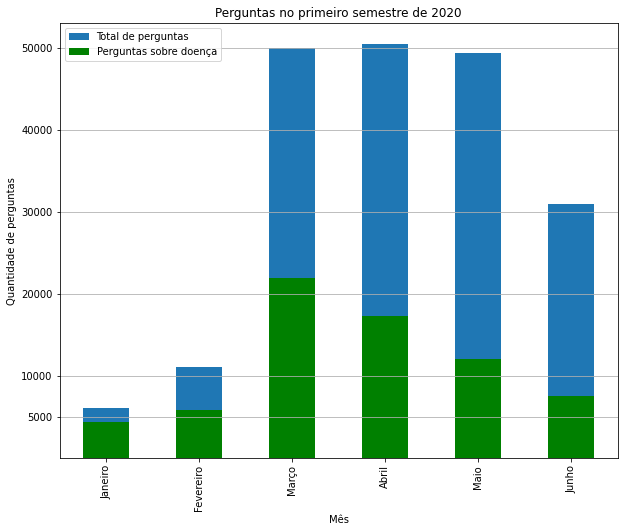

In [22]:
questions_df.groupby(questions_df.data.dt.month).texto.count().plot(kind='bar', figsize = (10, 8), label='Total de perguntas')
disease_tweets_df.groupby(disease_tweets_df.data.dt.month).texto.count().plot(kind="bar", figsize = (10, 8), color='g', label='Perguntas sobre doença')
plt.title('Perguntas no primeiro semestre de 2020')
plt.xlabel('Mês')
plt.ylabel('Quantidade de perguntas')
plt.xticks(ticks=np.arange(6), labels=['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho'])
plt.yticks(ticks=[5000, 10000, 20000, 30000, 40000, 50000])
plt.grid(axis='y')
plt.legend()
plt.show()

**Perguntas sobre doença pelo Brasil**

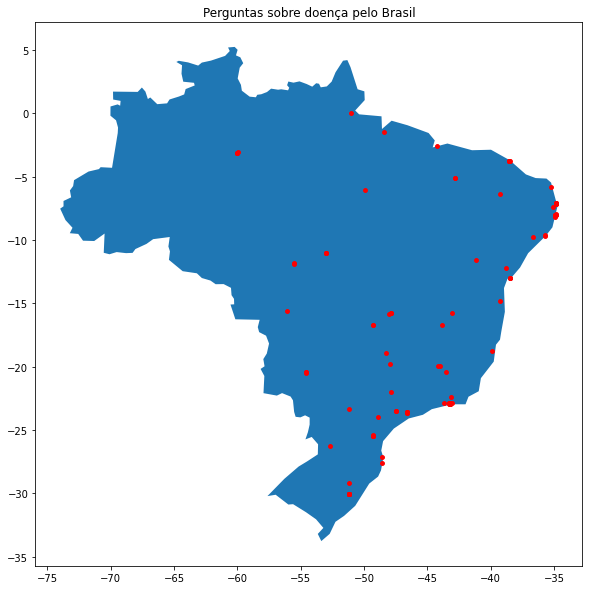

In [23]:
country = 'Brazil'
localized_tweets_df = disease_tweets_df.loc[disease_tweets_df.latitude.notnull() & disease_tweets_df.longitude.notnull() & disease_tweets_df.pais.eq(country)]
geometry = [Point(xy) for xy in zip(localized_tweets_df.latitude, localized_tweets_df.longitude)]
location_dic = {'tweet': localized_tweets_df.texto, 'geometry': geometry}
brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).loc[world.name == country]

tweets_gdf = gpd.GeoDataFrame(location_dic, geometry=geometry)
tweets_gdf.plot(ax=brazil.plot(figsize=(15, 10)), marker='o', color='red', markersize=15)
plt.title('Perguntas sobre doença pelo Brasil')
plt.show()

**Perguntas mais retweetadas sobre doença**


In [24]:
disease_tweets_df.sort_values(by='retweet', ascending=False).head()

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
76211,2020-03-22 03:43:41,jayne,jaynebullock14,RT @sineadxia: So shortness of breath is a corona symptom right but you know what also gives me shortness of breath?,107908,151,en,NaN,NaN,NaN,NaN,NaN,[]
132123,2020-03-21 22:11:51,Nana Caê,nanacae,Que tal um pouquinho de notícias boas sobre o coronavírus?,20205,39000,pt,NaN,NaN,NaN,NaN,NaN,[]
194613,2020-05-30 16:24:37,God'sChoice,PamelaAffect,RT @NYGovCuomo: Why are black people dying from #COVID at higher rates than white people?,17975,568,en,NaN,NaN,NaN,NaN,NaN,['COVID']
132641,2020-05-05 01:55:48,S@KS,skruse99,RT @charliekirk11: Why is the Left okay with Coronavirus ID cards but aggressively opposed to voter ID?,17038,130,en,NaN,NaN,NaN,NaN,NaN,[]
8536,2020-04-29 00:44:52,Antonio Tabet,antoniotabet,“Que pandemia?”\n2.,13791,3069833,pt,NaN,NaN,NaN,NaN,NaN,[]


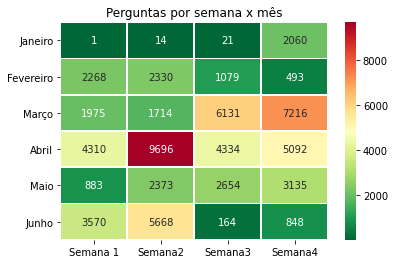

In [25]:
heatMap(disease_tweets_df,'Perguntas por semana x mês')

### Medicamento

In [26]:
is_medicine = questions_df.texto.str.contains('azitromicina|cloroquina|ivermectina|tamiflu|hidroxi', na=False, case=False)
medicine_tweets_df = questions_df.loc[is_medicine]
medicine_tweets_df

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
8,2020-04-08 22:04:51,lulleitao,lulleitao,"@JeanSCorrea7 Mas ele não deu a entender que o Tamiflu era melhor, neh?",0,2315,pt,NaN,NaN,NaN,NaN,NaN,[]
15,2020-03-30 19:22:45,Gisele Reis,GiseleReisSilva,@bbcbrasil @cavmota A pergunta que não quer calar: quem faz uso contínuo de hidroxicloroquina está imune ao vírus???,0,60,pt,NaN,NaN,NaN,NaN,NaN,[]
20,2020-06-04 15:02:36,Mira lo que tienes,NoDosOutros_,Problemas no paraíso da Cloroquina?,0,133,pt,NaN,NaN,NaN,NaN,NaN,[]
32,2020-03-28 14:05:59,Priscila Andrade Rodrigues,PriAndRodrigues,"@veramagalhaes VERBA 792K, FALE SOBRE A CLOROQUINA?",0,1777,pt,NaN,NaN,NaN,NaN,NaN,[]
48,2020-06-04 05:20:18,🇧🇷edivaldo1000🇧🇷,edivaldo1000,Será que a Renata vai tomar cloroquina William bonner?,2,49493,pt,NaN,NaN,NaN,NaN,NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197987,2020-05-24 20:09:57,Willian Fernandes,Willian11031987,Mais essa tal de cloroquina não é aquela que mata as pessoas?,0,2910,pt,NaN,NaN,NaN,NaN,NaN,[]
198011,2020-03-25 20:21:46,Lais S Vello,la_vello,Ou está tratando hidroxicloroquina?,0,105,pt,NaN,NaN,NaN,NaN,NaN,[]
198012,2020-05-15 21:04:20,marquinhos tavares,marcoosvieira,QUAIS os países estão usando cloroquina para tratamento do corona?,0,566,pt,NaN,NaN,NaN,NaN,NaN,[]
198022,2020-05-23 12:54:53,Andrea Mansur,Andrea_Mansur,?estamos usando cloroquina… https://t.co/wnPrh5jFyY,0,1618,pt,NaN,NaN,NaN,NaN,NaN,[]


**Quantidade de perguntas sobre medicamento em relação ao total de perguntas**

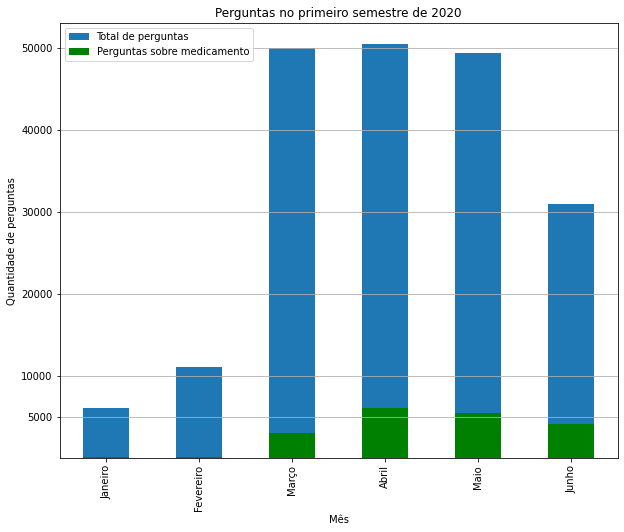

In [27]:
questions_df.groupby(questions_df.data.dt.month).texto.count().plot(kind='bar', figsize = (10, 8), label='Total de perguntas')
medicine_tweets_df.groupby(medicine_tweets_df.data.dt.month).texto.count().plot(kind="bar", figsize = (10, 8), color='g', label='Perguntas sobre medicamento')
plt.title('Perguntas no primeiro semestre de 2020')
plt.xlabel('Mês')
plt.ylabel('Quantidade de perguntas')
plt.xticks(ticks=np.arange(6), labels=['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho'])
plt.yticks(ticks=[5000, 10000, 20000, 30000, 40000, 50000])
plt.grid(axis='y')
plt.legend()
plt.show()

**Perguntas sobre medicamento pelo Brasil**

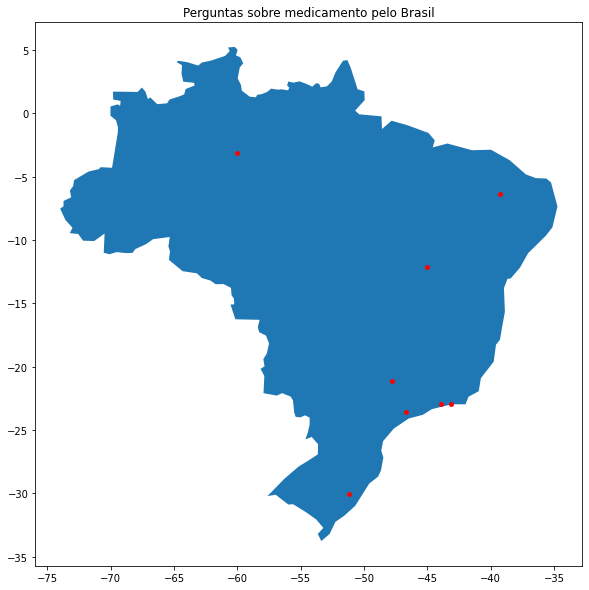

In [28]:
country = 'Brazil'
localized_tweets_df = medicine_tweets_df.loc[medicine_tweets_df.latitude.notnull() & medicine_tweets_df.longitude.notnull() & medicine_tweets_df.pais.eq(country)]
geometry = [Point(xy) for xy in zip(localized_tweets_df.latitude, localized_tweets_df.longitude)]
location_dic = {'tweet': localized_tweets_df.texto, 'geometry': geometry}
brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).loc[world.name == country]

tweets_gdf = gpd.GeoDataFrame(location_dic, geometry=geometry)
tweets_gdf.plot(ax=brazil.plot(figsize=(15, 10)), marker='o', color='red', markersize=15)
plt.title('Perguntas sobre medicamento pelo Brasil')
plt.show()

**Perguntas mais retweetadas sobre medicamento**

In [29]:
medicine_tweets_df.sort_values(by='retweet', ascending=False).head()

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
31673,2020-03-29 23:54:04,Arthur Weintraub,ArthurWeint,Sabe pq os marinho não mostram a hidroxicloroquina?,7593,502836,pt,NaN,NaN,NaN,NaN,NaN,[]
149679,2020-04-08 17:22:55,Augusto Nunes,augustosnunes,"A cloroquina agora é coisa da direita golpista, certo?",4409,902783,pt,NaN,NaN,NaN,NaN,NaN,[]
172195,2020-04-07 11:57:33,Igor Araujo,igoraraujojj,Sabe pq o Mandetta não é a favor da cloroquina?,4075,37219,pt,NaN,NaN,NaN,NaN,NaN,[]
173078,2020-04-07 10:56:44,Rodrigo Constantino,Rconstantino,Os negacionistas da hidroxicloroquina já passaram alguma vergonha hoje?,2964,441826,pt,NaN,NaN,NaN,NaN,NaN,[]
123047,2020-05-15 19:33:38,normose_🆘,Normose_,FIO: Pq Bolsonaro não abre mão da Cloroquina mesmo ?,2922,56067,pt,NaN,NaN,NaN,NaN,NaN,[]


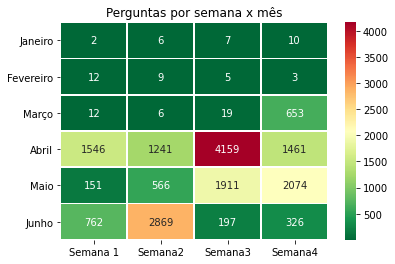

In [30]:
heatMap(medicine_tweets_df,'Perguntas por semana x mês')

### Organizações

In [31]:
are_organizations = questions_df.texto.str.contains('oms|organização|organizacao|organizações|governo|ministério da saúde|ministerio da saude|televisão|televisao|globo|sbt|g1|bbc|cnn', na=False, case=False)
organizations_tweets_df = questions_df.loc[are_organizations]
organizations_tweets_df

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
15,2020-03-30 19:22:45,Gisele Reis,GiseleReisSilva,@bbcbrasil @cavmota A pergunta que não quer calar: quem faz uso contínuo de hidroxicloroquina está imune ao vírus???,0,60,pt,NaN,NaN,NaN,NaN,NaN,[]
57,2020-04-08 21:14:58,PatriotRobot,PatriotRobot,"@CNNBrasil Só a Cloroquina já derruba os dois vírus, Ditadória deu dinheiro pra vocês?",0,663,pt,NaN,NaN,NaN,NaN,NaN,[]
80,2020-04-28 23:54:42,Gamarra Levy,LevyGamarra,Como o Ministério da Saúde administra a pandemia de coronavírus?,0,966,pt,NaN,NaN,NaN,NaN,NaN,[]
83,2020-03-26 21:53:27,Mary,ComentouMary,O que governo faz para melhorar isso?,0,1050,pt,NaN,NaN,NaN,NaN,NaN,[]
178,2020-04-14 01:27:28,LEO,CRUZ_LEO2,@desilvestre85 @g1 Qual hospital ?,0,6265,pt,NaN,NaN,NaN,NaN,NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197913,2020-05-10 18:41:44,Giuseppe Silva 🇵🇹🇮🇹,joseecarla9,@radiotupi NÃO seria culpa da GLOBO?!,0,163,pt,NaN,NaN,NaN,NaN,NaN,[]
197936,2020-05-14 12:52:06,Roberto Paixão,RobertoPaixo11,"#GrandeDebateCNN Tiago Anastácio, falou q faltou diálogo da parte do presidente, para o controle do covid?",0,16,pt,NaN,NaN,NaN,NaN,NaN,['GrandeDebateCNN']
198024,2020-01-29 18:37:44,Inês Santos 🚩em casa 🏡,mariasinha28,@ZugRS Mas a oms não tem um protocolo mundial de comportamento pra cada país?,0,339,pt,NaN,NaN,NaN,NaN,NaN,[]
198054,2020-05-31 16:23:36,❌ABORTO🚫DROGAS☠COMUNISMO,BolsonaroAte,@g1 E A QUARENTENA??,0,544,pt,NaN,NaN,NaN,NaN,NaN,[]


**Quantidade de perguntas sobre organizações em relação ao total de perguntas**

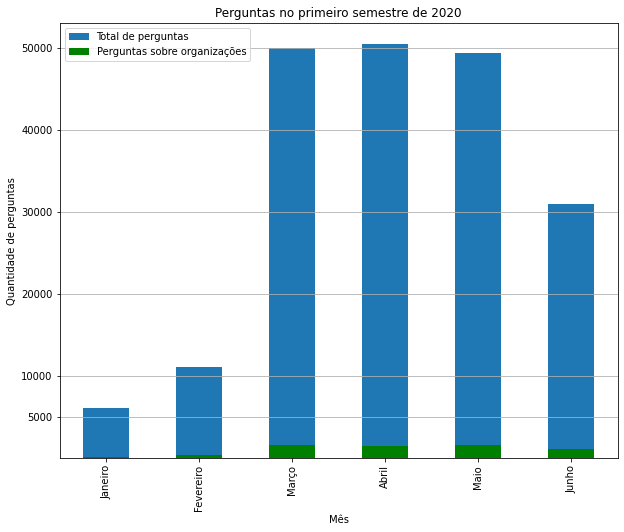

In [32]:
questions_df.groupby(questions_df.data.dt.month).texto.count().plot(kind='bar', figsize = (10, 8), label='Total de perguntas')
organizations_tweets_df.groupby(organizations_tweets_df.data.dt.month).texto.count().plot(kind="bar", figsize = (10, 8), color='g', label='Perguntas sobre organizações')
plt.title('Perguntas no primeiro semestre de 2020')
plt.xlabel('Mês')
plt.ylabel('Quantidade de perguntas')
plt.xticks(ticks=np.arange(6), labels=['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho'])
plt.yticks(ticks=[5000, 10000, 20000, 30000, 40000, 50000])
plt.grid(axis='y')
plt.legend()
plt.show()

**Perguntas sobre organizações pelo Brasil**

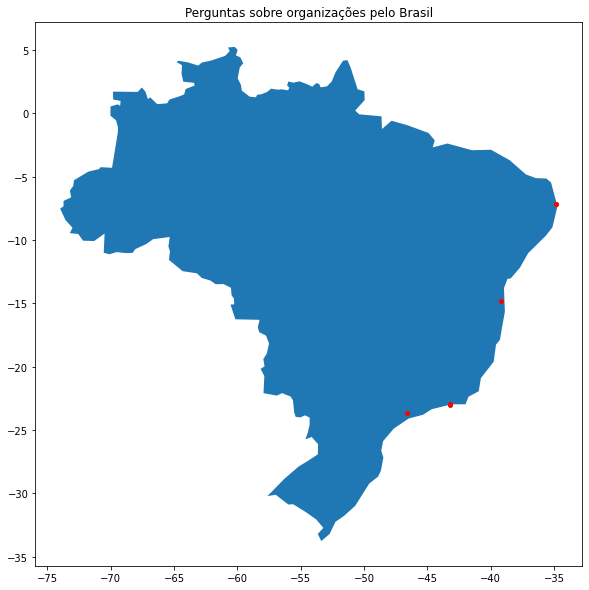

In [33]:
country = 'Brazil'
localized_tweets_df = organizations_tweets_df.loc[organizations_tweets_df.latitude.notnull() & organizations_tweets_df.longitude.notnull() & organizations_tweets_df.pais.eq(country)]
geometry = [Point(xy) for xy in zip(localized_tweets_df.latitude, localized_tweets_df.longitude)]
location_dic = {'tweet': localized_tweets_df.texto, 'geometry': geometry}
brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).loc[world.name == country]

tweets_gdf = gpd.GeoDataFrame(location_dic, geometry=geometry)
tweets_gdf.plot(ax=brazil.plot(figsize=(15, 10)), marker='o', color='red', markersize=15)
plt.title('Perguntas sobre organizações pelo Brasil')
plt.show()

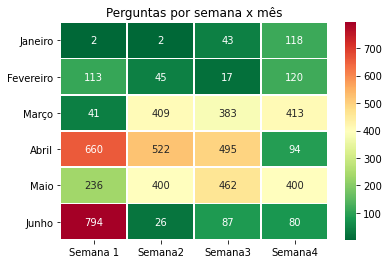

In [34]:
heatMap(organizations_tweets_df,'Perguntas por semana x mês')

**Perguntas mais retweetadas sobre organizações**

In [35]:
organizations_tweets_df.sort_values(by='retweet', ascending=False).head()

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
116358,2020-01-23 21:05:09,sarah☀️,simplyhobbit,RT @SavRealm: CNN said the world is $217 trillion dollars in debt... who tf we owe?,132941,203,en,NaN,NaN,NaN,NaN,NaN,[]
24205,2020-05-31 20:32:45,um maluco em pedaços,misterlonlyy,RT @npsidoka: antifacismo ser considerada uma organização terrorista?,3151,85,pt,NaN,NaN,NaN,NaN,NaN,[]
97565,2020-05-11 18:55:58,@Deni,DenivalRosendo,RT @FlavioBolsonaro: - Imagina tomar conhecimento das ações do governo somente através de alguns jornais e canais de televisão?,2545,175,pt,NaN,NaN,NaN,NaN,NaN,[]
71080,2020-05-13 21:19:50,Alonso 😎🖖🇧🇷🇪🇸🥁🏃‍♂️🤖🥛,Maralon31389069,RT @atldoficial: Que país é esse onde o celular do advogado do Adelio não pode ser inspecionado e a reunião estratégica de governo pode?,1568,272,pt,NaN,NaN,NaN,NaN,NaN,[]
77957,2020-05-26 11:05:13,Sarah 🇩🇿,satwiceu,RT @tzujype: many fandoms are accusing Twice for copying their favs?,1038,87,en,NaN,NaN,NaN,NaN,NaN,[]


### Pessoas

In [36]:
are_people = questions_df.texto.str.contains('mandetta|ministro|jair|bolsonaro|deputado|presidente|juiz|pazuello|teich|prefeito|vereador', na=False, case=False)
people_tweets_df = questions_df.loc[are_people]
people_tweets_df

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-03-23 18:51:14,Gaboardi,fraslee,@BolsonaroSP Cade o fundão deputado???,0,138,pt,NaN,NaN,NaN,NaN,NaN,[]
7,2020-05-15 18:15:33,Silveacyr Maria Coelho Santos,silveacyr,@mitags Será por que o Bolsonaro não fez propaganda?,0,67,pt,NaN,NaN,NaN,NaN,NaN,[]
16,2020-03-18 17:15:18,why so serious?,ph_Dasein,Você iria na festa de aniversário de @jairbolsonaro ?,0,181,pt,NaN,NaN,NaN,NaN,NaN,"['COVID19', 'Covid_19', 'Bolsonaroacabou', 'panelaco18M']"
65,2020-03-24 23:40:18,eu que lute 🏳️‍🌈⃤,allisonanjos,É sério que o presidente mandou os governadores pararem com a quarentena?,1,1384,pt,NaN,NaN,NaN,NaN,NaN,[]
71,2020-04-15 19:59:04,Gabrielle,gabiiiaquiino,@jairbolsonaro \nComo vc demite uma pessoa que tá alertando pessoas sobre o perigo da quarentena?,0,483,pt,NaN,NaN,NaN,NaN,NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197992,2020-03-12 19:04:32,Léo Araújo,leo_araujo2109,"@BolsonaroSP @fabiowoficial @conexaopolitica Ué, mas o Covid-19 não era uma fantasia?",0,8,pt,NaN,NaN,NaN,NaN,NaN,[]
197996,2020-06-01 16:12:55,Ana Paula 🌹🇧🇷🕊️,AdvDeus,Cadê o Ministro da Saúde???,2,227,pt,NaN,NaN,NaN,NaN,NaN,['coronavirus']
198009,2020-03-25 20:21:46,Lais S Vello,la_vello,@jairbolsonaro Você fez?,0,105,pt,NaN,NaN,NaN,NaN,NaN,[]
198025,2020-02-24 01:06:27,claudio,claudio29964592,@CarlosBolsonaro e daí ???,0,14,pt,NaN,NaN,NaN,NaN,NaN,[]


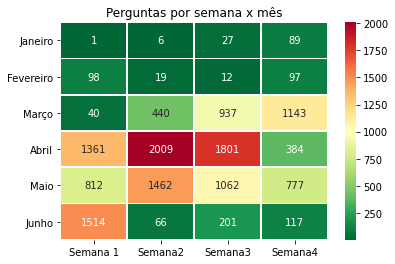

In [37]:
heatMap(people_tweets_df,'Perguntas por semana x mês')

**Quantidade de perguntas sobre pessoas em relação ao total de perguntas**

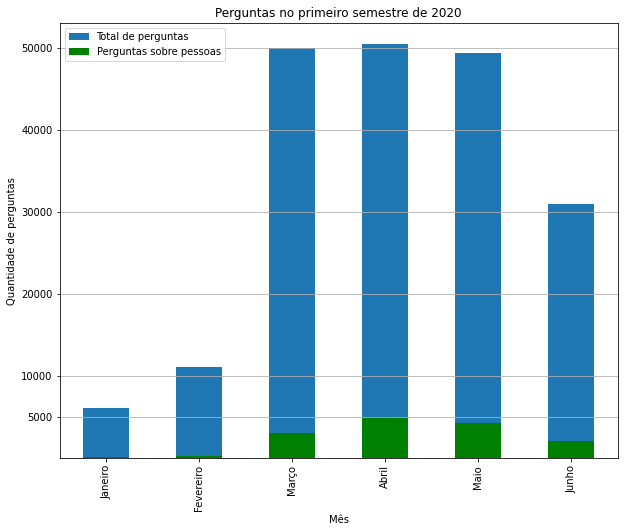

In [38]:
questions_df.groupby(questions_df.data.dt.month).texto.count().plot(kind='bar', figsize = (10, 8), label='Total de perguntas')
people_tweets_df.groupby(people_tweets_df.data.dt.month).texto.count().plot(kind="bar", figsize = (10, 8), color='g', label='Perguntas sobre pessoas')
plt.title('Perguntas no primeiro semestre de 2020')
plt.xlabel('Mês')
plt.ylabel('Quantidade de perguntas')
plt.xticks(ticks=np.arange(6), labels=['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho'])
plt.yticks(ticks=[5000, 10000, 20000, 30000, 40000, 50000])
plt.grid(axis='y')
plt.legend()
plt.show()

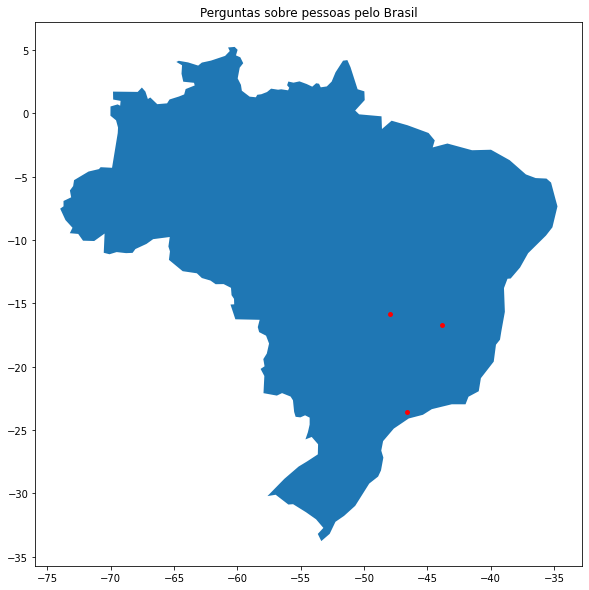

In [39]:
country = 'Brazil'
localized_tweets_df = people_tweets_df.loc[people_tweets_df.latitude.notnull() & people_tweets_df.longitude.notnull() & people_tweets_df.pais.eq(country)]
geometry = [Point(xy) for xy in zip(localized_tweets_df.latitude, localized_tweets_df.longitude)]
location_dic = {'tweet': localized_tweets_df.texto, 'geometry': geometry}
brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).loc[world.name == country]

tweets_gdf = gpd.GeoDataFrame(location_dic, geometry=geometry)
tweets_gdf.plot(ax=brazil.plot(figsize=(15, 10)), marker='o', color='red', markersize=15)
plt.title('Perguntas sobre pessoas pelo Brasil')
plt.show()

**Perguntas mais retweetadas sobre pessoas**

In [40]:
people_tweets_df.sort_values(by='retweet', ascending=False).head()

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
114768,2020-05-15 18:20:50,Carolina Hartung,Carol_Hartc,RT @gugachacra: Quem aceitará ser ministro da Saúde?,10676,2877,pt,NaN,NaN,NaN,NaN,NaN,[]
32240,2020-05-15 16:41:58,Carlos Gomes,carlosjgomes,RT @gugachacra: Quem aceitará ser ministro da Saúde?,10661,15,pt,NaN,NaN,NaN,NaN,NaN,[]
75799,2020-06-02 19:56:17,Emília Dourado,EmiliaDourado3,"Agora é culpa do bolsonaro ?""",9752,3047,pt,NaN,NaN,NaN,NaN,NaN,[]
195887,2020-05-05 16:47:37,Gadelha 🇧🇷🇮🇱🇺🇸,gadelhapatrick,"RT @BolsonaroSP: Protestos democráticos são esses aí das imagens, talkei?",5643,246,pt,NaN,NaN,NaN,NaN,NaN,[]
119432,2020-05-09 01:09:14,Guga Chacra 🇧🇷🇺🇸🇱🇧🇮🇹🇦🇷,gugachacra,Pq Bolsonaro não apresenta o exame do coronavírus?,4583,1124604,pt,NaN,NaN,NaN,NaN,NaN,[]


### Comparativo entre os temas das perguntas

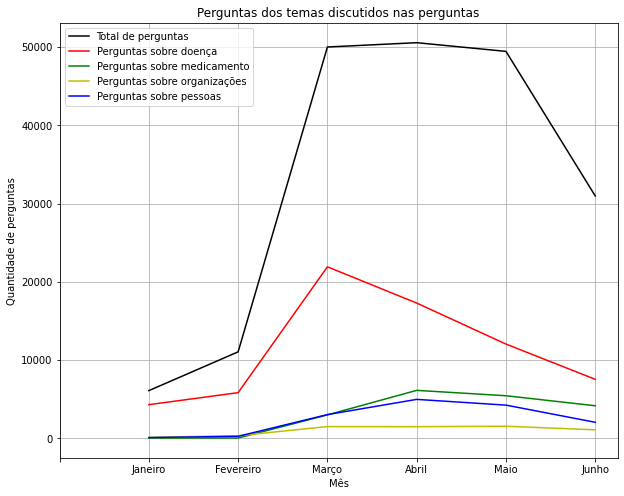

In [41]:
questions_df.groupby(questions_df.data.dt.month).texto.count().plot(figsize = (10, 8), label='Total de perguntas', color='k')
disease_tweets_df.groupby(disease_tweets_df.data.dt.month).texto.count().plot(figsize = (10, 8), color='r', label='Perguntas sobre doença')
medicine_tweets_df.groupby(medicine_tweets_df.data.dt.month).texto.count().plot(figsize = (10, 8), color='g', label='Perguntas sobre medicamento')
organizations_tweets_df.groupby(organizations_tweets_df.data.dt.month).texto.count().plot(figsize = (10, 8), color='y', label='Perguntas sobre organizações')
people_tweets_df.groupby(people_tweets_df.data.dt.month).texto.count().plot(figsize = (10, 8), color='b', label='Perguntas sobre pessoas')

plt.title('Perguntas dos temas discutidos nas perguntas')
plt.xlabel('Mês')
plt.ylabel('Quantidade de perguntas')
plt.xticks(ticks=np.arange(7), labels=[None, 'Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho'])
plt.legend()
plt.grid()

## Visão diária das perguntas



In [42]:
date = '2020-06-10'  #@param {type: "date"}
#@markdown ---
#date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')

# run this line only first time
#questions_df['data'] = questions_df['data'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

date_time_str = date
date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')
interval = (questions_df.data.dt.date == date_time_obj.date() ) 
df_interval = questions_df.loc[interval]
print("Total de perguntas no dia: " + date )
df_interval.shape



Total de perguntas no dia: 2020-06-10


(125, 13)

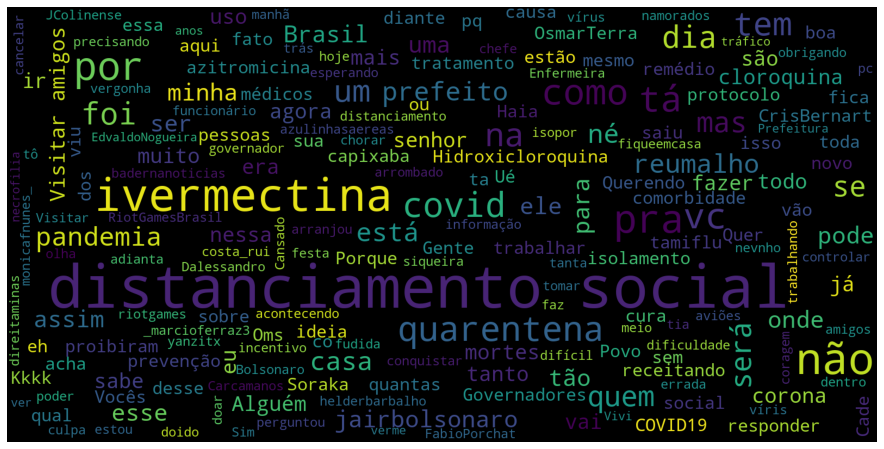

In [43]:
all_tweets = " ".join(s for s in df_interval.texto)
wordcloud = WordCloud(stopwords=stopwords, background_color='black', width=1600, height=800).generate(all_tweets)

fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)
plt.show()

Número de perguntas por **horário**:

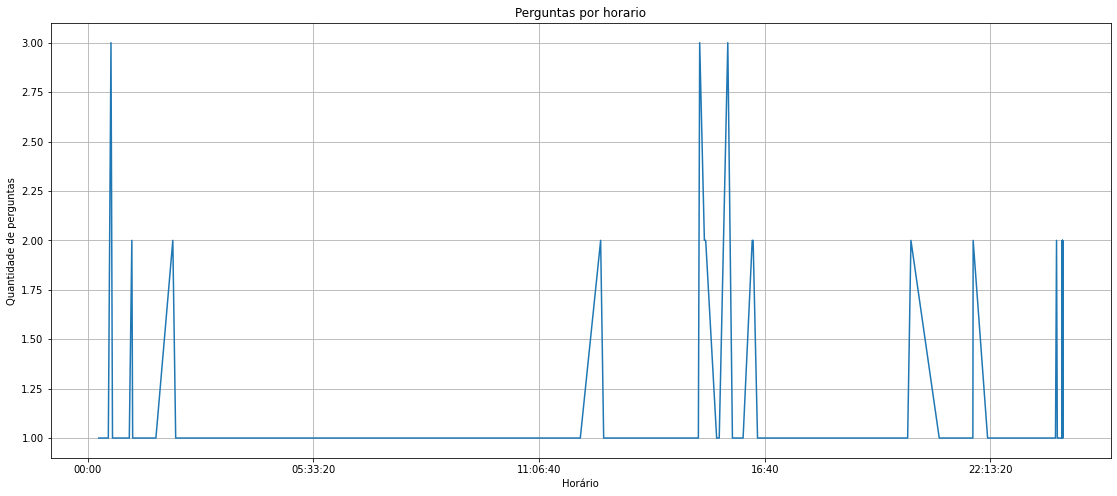

In [44]:
horarios = df_interval.data.dt.time
grouped_df = df_interval.groupby(df_interval.data.dt.time).size()

grouped_df.plot(figsize = (19, 8))
plt.title('Perguntas por horario')
plt.xlabel('Horário')
plt.ylabel('Quantidade de perguntas')
plt.grid()
plt.show()